In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Data Preprocessing
ratings_df = pd.read_csv('/content/ratings.csv')

user2id = {uid: i for i, uid in enumerate(ratings_df['user_id'].unique())}
book2id = {bid: i for i, bid in enumerate(ratings_df['book_id'].unique())}

ratings_df['user'] = ratings_df['user_id'].map(user2id)
ratings_df['item'] = ratings_df['book_id'].map(book2id)
ratings_df['label'] = (ratings_df['rating'] >= 4).astype(int)

num_users = len(user2id)
num_items = len(book2id)

train_df, test_df = train_test_split(ratings_df[['user', 'item', 'label']], test_size=0.2, random_state=42)

# Dataset Classes
class RecommenderDataset(Dataset):
    def __init__(self, df, num_items, is_training=True):
        self.df = df
        self.num_items = num_items
        self.is_training = is_training
        self.data = self._build()

    def _build(self):
        data = []
        for _, row in self.df.iterrows():
            u, i, l = row['user'], row['item'], row['label']
            data.append((u, i, l))
            if self.is_training and l == 1:
                for _ in range(3):
                    neg = random.randint(0, self.num_items - 1)
                    while neg == i:
                        neg = random.randint(0, self.num_items - 1)
                    data.append((u, neg, 0))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long)

# NeuMF Model
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=32):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(2 * emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, users, items):
        u = self.user_emb(users)
        i = self.item_emb(items)
        x = torch.cat([u, i], dim=1)
        return self.mlp(x)

# SASRec Model
class SASRecDataset(Dataset):
    def __init__(self, user_sequences, num_items, max_seq_len=50, neg_ratio=1):
        self.user_sequences = user_sequences
        self.num_items = num_items
        self.max_seq_len = max_seq_len
        self.neg_ratio = neg_ratio
        self.data = self._build()

    def _build(self):
        data = []
        for u, seq in self.user_sequences.items():
            for t in range(1, len(seq)):
                prefix = seq[:t]
                target = seq[t]
                if len(prefix) > self.max_seq_len:
                    prefix = prefix[-self.max_seq_len:]
                pad_len = self.max_seq_len - len(prefix)
                padded = [0]*pad_len + [i+1 for i in prefix]
                data.append((u, torch.tensor(padded), target+1, 1))
                for _ in range(self.neg_ratio):
                    neg = random.randint(0, self.num_items - 1)
                    while neg in seq:
                        neg = random.randint(0, self.num_items - 1)
                    data.append((u, torch.tensor(padded), neg+1, 0))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class SASRec(nn.Module):
    def __init__(self, num_items, max_seq_len=50, emb_dim=64, n_heads=2, n_layers=2, dropout=0.2):
        super().__init__()
        self.item_emb = nn.Embedding(num_items + 1, emb_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_seq_len, emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads, dim_feedforward=emb_dim*4, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(emb_dim)

    def forward(self, seq, target):
        pos = torch.arange(seq.size(1), device=seq.device).unsqueeze(0)
        x = self.item_emb(seq) + self.pos_emb(pos)
        x = self.norm(self.dropout(x))
        x = self.encoder(x)
        user_vec = x[:, -1, :]
        item_vec = self.item_emb(target)
        return (user_vec * item_vec).sum(-1)

# LightGCN Model
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, edge_users, edge_items, n_layers=3, emb_dim=64):
        super(LightGCN, self).__init__()
        self.n_layers = n_layers
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.edge_users = torch.LongTensor(edge_users)
        self.edge_items = torch.LongTensor(edge_items)
        self.user_deg = torch.FloatTensor(user_deg)
        self.item_deg = torch.FloatTensor(item_deg)
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)

    def propagate(self):
        device = self.user_emb.weight.device
        edge_users = self.edge_users.to(device)
        edge_items = self.edge_items.to(device)
        user_deg = self.user_deg.to(device)
        item_deg = self.item_deg.to(device)

        u = self.user_emb.weight
        i = self.item_emb.weight
        all_u = u.clone()
        all_i = i.clone()

        for _ in range(self.n_layers):
            u_agg = torch.zeros_like(u).index_add(0, edge_users, i[edge_items])
            i_agg = torch.zeros_like(i).index_add(0, edge_items, u[edge_users])
            u = u_agg / user_deg.unsqueeze(1)
            i = i_agg / item_deg.unsqueeze(1)
            all_u += u
            all_i += i

        return all_u / (self.n_layers + 1), all_i / (self.n_layers + 1)

    def predict(self, users, items):
        u_all, i_all = self.propagate()
        return (u_all[users] * i_all[items]).sum(dim=1)

    def forward(self, users, items):
        return self.predict(users, items)


# Training and Evaluation
def train_model(model, loader, optimizer, criterion, device):
    model.train()
    for batch in tqdm(loader):
        u, i, l = batch[:,0].to(device), batch[:,1].to(device), batch[:,2].float().to(device)
        pred = model(u, i).squeeze()
        loss = criterion(pred, l)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def train_sasrec(model, dataset, device):
    loader = DataLoader(dataset, batch_size=128, shuffle=True)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    crit = nn.BCEWithLogitsLoss()
    model.to(device)
    for epoch in range(3):
        model.train()
        for u, seq, item, label in tqdm(loader, desc=f"SASRec Epoch {epoch+1}"):
            seq, item, label = seq.to(device), item.to(device), label.float().to(device)
            pred = model(seq, item)
            loss = crit(pred, label)
            opt.zero_grad()
            loss.backward()
            opt.step()

def train_lightgcn(model, loader, device):
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    crit = nn.BCEWithLogitsLoss()
    model.to(device)
    for epoch in range(3):
        model.train()
        for batch in tqdm(loader, desc=f"LightGCN Epoch {epoch+1}"):
            u, i, l = batch[:,0].to(device), batch[:,1].to(device), batch[:,2].float().to(device)
            pred = model.predict(u, i)
            loss = crit(pred, l)
            opt.zero_grad()
            loss.backward()
            opt.step()

def hit_ndcg(model, test_df, num_items, device, k=10):
    model.eval()
    hits, ndcgs = [], []
    for u in test_df['user'].unique():
        pos = test_df[test_df['user'] == u]['item'].values[0]
        items = [pos] + random.sample([i for i in range(num_items) if i != pos], 99)
        users = torch.tensor([u]*len(items)).to(device)
        items_tensor = torch.tensor(items).to(device)
        with torch.no_grad():
            scores = model(users, items_tensor).squeeze().cpu().numpy()
        ranked = np.argsort(-scores)
        top_k = [items[i] for i in ranked[:k]]
        if pos in top_k:
            hits.append(1)
            ndcgs.append(1 / np.log2(top_k.index(pos) + 2))
        else:
            hits.append(0)
            ndcgs.append(0)
    return np.mean(hits), np.mean(ndcgs)

def evaluate_sasrec(model, test_df, user_sequences, num_items, device, k=10):
    model.eval()
    hits, ndcgs = [], []

    for user in test_df['user'].unique():
        pos_item = test_df[test_df['user'] == user]['item'].values[0]
        items = [pos_item] + random.sample([i for i in range(num_items) if i != pos_item], 99)
        items = list(set(items))
        items_tensor = torch.tensor(items, dtype=torch.long).to(device)
        seq = user_sequences.get(user, [])
        if len(seq) > 50:
            seq = seq[-50:]
        pad_len = 50 - len(seq)
        seq_tensor = torch.tensor([0]*pad_len + [i+1 for i in seq], dtype=torch.long).unsqueeze(0).repeat(len(items), 1).to(device)
        with torch.no_grad():
            scores = model(seq_tensor, items_tensor).detach().cpu().numpy()
        ranked_indices = np.argsort(-scores)
        top_k_items = [items[i] for i in ranked_indices[:k]]
        if pos_item in top_k_items:
            hits.append(1)
            rank = top_k_items.index(pos_item) + 1
            ndcgs.append(1 / np.log2(rank + 1))
        else:
            hits.append(0)
            ndcgs.append(0)

    return np.mean(hits), np.mean(ndcgs)

# Execute All
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# NeuMF
neumf = NeuMF(num_users, num_items).to(device)
neumf_loader = DataLoader(RecommenderDataset(train_df, num_items), batch_size=1024, shuffle=True)
train_model(neumf, neumf_loader, torch.optim.Adam(neumf.parameters(), lr=0.001), nn.BCELoss(), device)
hit, ndcg = hit_ndcg(neumf, test_df, num_items, device)
print(f"NeuMF HR@10: {hit:.4f}, NDCG@10: {ndcg:.4f}")

# SASRec
train_pos = train_df[train_df['label'] == 1][['user', 'item']].sort_values(['user', 'item'])
user_sequences = train_pos.groupby('user')['item'].apply(list).to_dict()
sasrec_data = SASRecDataset(user_sequences, num_items)
sasrec = SASRec(num_items+1).to(device)
train_sasrec(sasrec, sasrec_data, device)
hit, ndcg = evaluate_sasrec(sasrec, test_df, user_sequences, num_items, device)
print(f"SASRec HR@10: {hit:.4f}, NDCG@10: {ndcg:.4f}")

# LightGCN
edge_users = train_df[train_df['label'] == 1]['user'].tolist()
edge_items = train_df[train_df['label'] == 1]['item'].tolist()

# Compute degrees
user_deg = np.zeros(num_users, dtype=np.float32)
item_deg = np.zeros(num_items, dtype=np.float32)
for u, i in zip(edge_users, edge_items):
    user_deg[u] += 1
    item_deg[i] += 1
user_deg[user_deg == 0] = 1.0
item_deg[item_deg == 0] = 1.0

lightgcn = LightGCN(num_users, num_items, edge_users, edge_items).to(device)
lightgcn_loader = DataLoader(RecommenderDataset(train_df, num_items), batch_size=1024, shuffle=True)
train_lightgcn(lightgcn, lightgcn_loader, device)
hit, ndcg = hit_ndcg(lightgcn, test_df, num_items, device)
print(f"LightGCN HR@10: {hit:.4f}, NDCG@10: {ndcg:.4f}")


100%|██████████| 2292/2292 [00:22<00:00, 103.89it/s]


NeuMF HR@10: 0.0962, NDCG@10: 0.0438


SASRec Epoch 3: 100%|██████████| 7351/7351 [00:52<00:00, 139.87it/s]


SASRec HR@10: 0.1021, NDCG@10: 0.0464


LightGCN Epoch 3: 100%|██████████| 2292/2292 [01:32<00:00, 24.72it/s]


LightGCN HR@10: 0.4884, NDCG@10: 0.3011


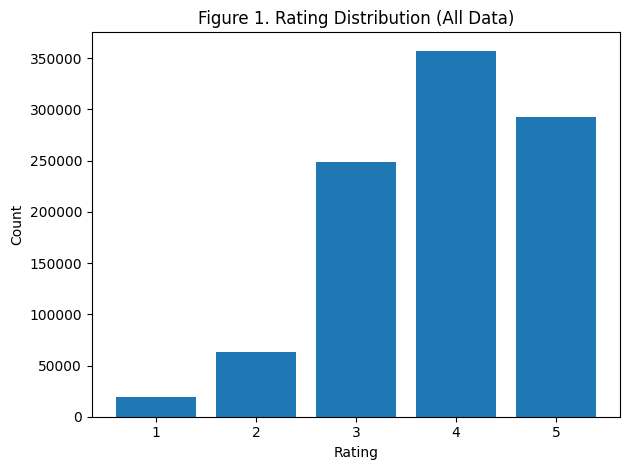

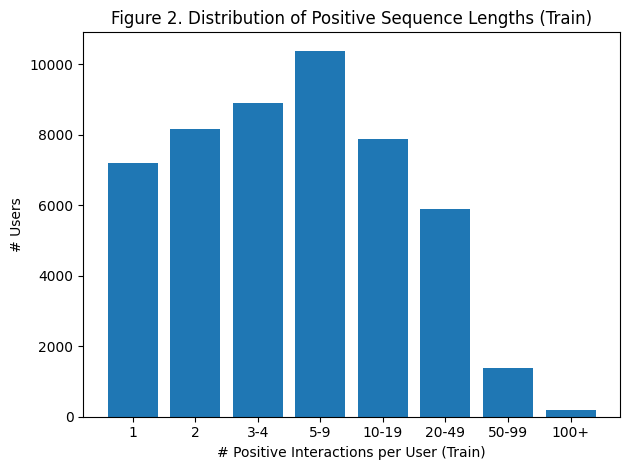

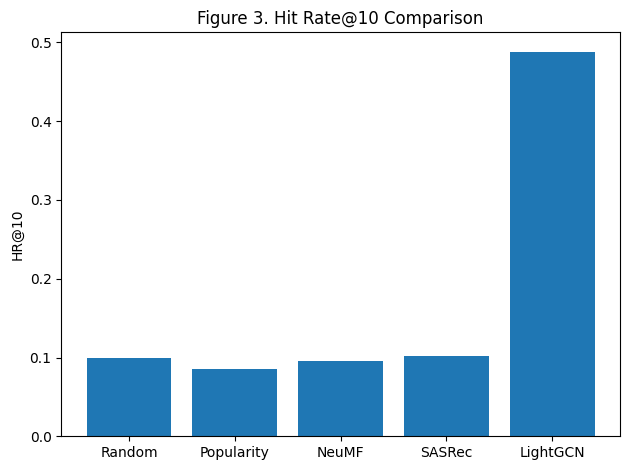

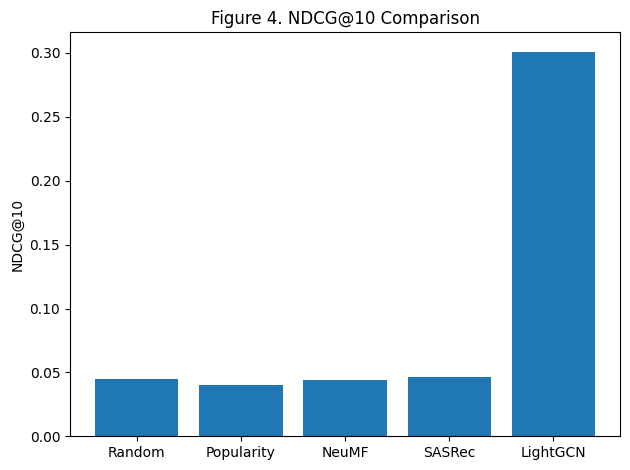

In [ ]:
import pandas as pd, numpy as np, random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load data
ratings = pd.read_csv("/content/ratings.csv")
ratings['label'] = (ratings['rating'] >= 4).astype(int)

# id remap
user2id = {u:i for i,u in enumerate(ratings['user_id'].unique())}
item2id = {b:i for i,b in enumerate(ratings['book_id'].unique())}
ratings['user'] = ratings['user_id'].map(user2id)
ratings['item'] = ratings['book_id'].map(item2id)

train_df, test_df = train_test_split(ratings[['user','item','label']], test_size=0.2, random_state=42)
num_items = ratings['item'].nunique()

# Figure Rating Distribution
rating_counts = ratings['rating'].value_counts().sort_index()
plt.figure()
plt.bar(rating_counts.index.astype(str), rating_counts.values)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Figure 1. Rating Distribution (All Data)")
plt.tight_layout()
plt.show()

# Figure Positive Sequence Lengths (Train)
train_pos = train_df[train_df['label']==1]
seq_counts = train_pos.groupby('user').size().values
hist, edges = np.histogram(seq_counts, bins=[0,1,2,3,5,10,20,50,100,10**9])
labels = ["1","2","3-4","5-9","10-19","20-49","50-99","100+"]
plt.figure()
plt.bar(labels, hist[1:])
plt.xlabel("# Positive Interactions per User (Train)")
plt.ylabel("# Users")
plt.title("Figure 2. Distribution of Positive Sequence Lengths (Train)")
plt.tight_layout()
plt.show()

# model metrics
metrics = pd.DataFrame([
    ("Random", 0.0988, 0.0451),
    ("Popularity", 0.0854, 0.0399),
    ("NeuMF", 0.0962, 0.0438),
    ("SASRec", 0.1021, 0.0464),
    ("LightGCN", 0.4884, 0.3011),
], columns=["Model","HR@10","NDCG@10"])

# Figure HR@10
plt.figure()
plt.bar(metrics["Model"], metrics["HR@10"])
plt.ylabel("HR@10")
plt.title("Figure 3. Hit Rate@10 Comparison")
plt.tight_layout()
plt.show()

# Figure NDCG@10
plt.figure()
plt.bar(metrics["Model"], metrics["NDCG@10"])
plt.ylabel("NDCG@10")
plt.title("Figure 4. NDCG@10 Comparison")
plt.tight_layout()
plt.show()
